<div >
<img src = "figs/ans_banner_1920x200.png" />
</div>

# Caso-taller:  SVD en reconocimiento facial

En este caso-taller vamos a aplicar SVD para hacer reconocimiento facial. Esta aplicación se conoce como caras propias, o eigenfaces en inglés, y si bien es una forma rudimentaria de reconocimiento facial sus resultados pueden ser muy interesantes. El problema de las caras propias fue estudiado por primera vez por Sirovich y Kirby en 1987, ampliado en 1990 y su aplicación al reconocimiento facial automatizado fue presentado por Turk and Pentland en 1991.

En este taller vamos a utilizar la base de datos conocida como Caras Etiquetadas en la Naturaleza, o Labeled Faces in the Wild (LFW). Esta base es provista por la Universidad de Massachusetts Amherst para que la comunidad académica la utilice para la evaluación de modelos predictivos.

La base contiene más de 13.000 imágenes de rostros recopilados de la web y cada cara ha sido etiquetada con el nombre de la persona representada. Un subconjunto de 1.680 de las personas fotografiadas tienen dos o más fotos distintas en el conjunto de datos. 


 
#### Referencias

- G. B. Huang,  M. Ramesh, T. Berg, and E. Learned-Miller. Labeled Faces in the Wild: A Database for Studying Face Recognition in Unconstrained Environments. University of Massachusetts, Amherst, Technical Report 07-49, October, 2007.

- M. Kirby and L. Sirovich. Application of the Karhunen-Loève procedure for the characterization of human faces. IEEE Transactions on Pattern Analysis and Machine Intelligence (PAMI), 12(1):103–108, 1990.

- L. Sirovich and M. Kirby. A low-dimensional procedure for the characterization of human faces. Journal of the Optical Society of America A, 4(3):519–524, 1987

- M. Turk and A. Pentland. Eigenfaces for recognition. Journal of Cognitive Neuroscience, 3(1):71–86, 1991.

## Instrucciones generales

1. Para desarrollar el *cuaderno* primero debe descargarlo.

2. Para responder cada inciso deberá utilizar el espacio debidamente especificado.

3. La actividad será calificada sólo si sube el *cuaderno* de jupyter notebook con extensión `.ipynb` en la actividad designada como "Revisión por el compañero".

4. El archivo entregado debe poder ser ejecutado localmente por los pares. Sea cuidadoso con la especificación de la ubicación de los archivos de soporte, guarde la carpeta de datos  en la misma ruta de acceso del cuaderno, por ejemplo: `data`.

## Desarrollo


### 1. Carga de datos 

Los datos pueden ser descargados directamente utilizando la librería `scikit-learn`, para ello cargue la base utilizando la función `fetch_lfw_people`. Esta función verificará si los datos están disponibles. De no estarlo, `scikit-learn` los descargará automáticamente desde el sitio web de la Universidad de Massachusetts. Descargue las imágenes para individuos que tengan al menos 25 imágenes y guárdelos en una carpeta llamada `data` usando esta función.

In [26]:
from sklearn.datasets import fetch_lfw_people
import os
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import TruncatedSVD
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score

In [2]:
# Paso 1: Descargar los datos con al menos 25 imágenes por individuo
lfw_people = fetch_lfw_people(min_faces_per_person=25, resize=1.0, color=True)

# Paso 2: Crear la carpeta 'data' si no existe
output_dir = 'data'
if not os.path.exists(output_dir):
    os.makedirs(output_dir)
else:
    # Eliminar todas las imágenes existentes en la carpeta 'data'
    for filename in os.listdir(output_dir):
        file_path = os.path.join(output_dir, filename)
        if os.path.isfile(file_path):
            os.remove(file_path)


# Paso 3: Guardar las imágenes en la carpeta 'data'
for i, (image, target) in enumerate(zip(lfw_people.images, lfw_people.target)):
    # Obtener el nombre del individuo
    target_name = lfw_people.target_names[target]
    
    # Convertir la imagen a formato PIL (RGB)
    img = Image.fromarray(image.astype('uint8'), 'RGB')
    
    # Crear un nombre de archivo único
    filename = f"{target_name}_{i}.jpg"
    
    # Guardar la imagen en la carpeta 'data'
    img.save(os.path.join(output_dir, filename))

print(f"Se guardaron {i+1} imágenes en la carpeta '{output_dir}'")

Se guardaron 2588 imágenes en la carpeta 'data'


(Utilice este espacio para describir su procedimiento)

### 2.  Análisis preliminar 

Describa los contenidos de la base, tenga en cuenta que debe detallar los elementos, la dimensión de la base, y la dimensión de las imágenes. 

In [3]:
# Paso 3: Describir el contenido de la base
n_samples, h, w, n_channels = lfw_people.images.shape
n_classes = lfw_people.target_names.shape[0]
target_counts = np.bincount(lfw_people.target)

print(f"Número total de imágenes: {n_samples}")
print(f"Número total de individuos: {n_classes}")
print(f"Dimensiones de cada imagen: {h}x{w} píxeles con {n_channels} canal(es) de color")
print(f"Número promedio de imágenes por persona: {n_samples / n_classes:.2f}")
print(f"Número mínimo de imágenes por persona: {target_counts.min()}")
print(f"Número máximo de imágenes por persona: {target_counts.max()}")

# Paso 4: Detalle de algunos ejemplos de individuos
print("\nAlgunos individuos en la base de datos:")
for i, name in enumerate(lfw_people.target_names[:10]):  # Mostrar los primeros 10 individuos
    print(f"Individuo {i+1}: {name} ({target_counts[i]} imágenes)")

Número total de imágenes: 2588
Número total de individuos: 42
Dimensiones de cada imagen: 125x94 píxeles con 3 canal(es) de color
Número promedio de imágenes por persona: 61.62
Número mínimo de imágenes por persona: 25
Número máximo de imágenes por persona: 530

Algunos individuos en la base de datos:
Individuo 1: Alejandro Toledo (39 imágenes)
Individuo 2: Alvaro Uribe (35 imágenes)
Individuo 3: Andre Agassi (36 imágenes)
Individuo 4: Ariel Sharon (77 imágenes)
Individuo 5: Arnold Schwarzenegger (42 imágenes)
Individuo 6: Bill Clinton (29 imágenes)
Individuo 7: Colin Powell (236 imágenes)
Individuo 8: David Beckham (31 imágenes)
Individuo 9: Donald Rumsfeld (121 imágenes)
Individuo 10: George W Bush (530 imágenes)


## 2. Análisis Preliminar de la Base de Datos LFW

### Procedimiento

Para comenzar con el análisis de la base de datos **Labeled Faces in the Wild (LFW)**, primero cargamos las imágenes y las etiquetas asociadas utilizando la función `fetch_lfw_people` de `sklearn`. Esta base de datos contiene imágenes etiquetadas de rostros de personas famosas, las cuales se utilizan comúnmente en tareas de reconocimiento facial.

Luego, realizamos un análisis para determinar la estructura y composición de la base de datos, enfocándonos en los siguientes aspectos:
- El número total de imágenes en la base de datos.
- El número total de individuos (clases) representados.
- Las dimensiones de cada imagen, tanto en términos de altura, anchura, y número de canales de color.
- La distribución del número de imágenes por persona, identificando el mínimo, máximo y promedio de imágenes por clase.

### Análisis

El análisis de la base de datos produjo los siguientes resultados:

- **Número total de imágenes**: 2,588
- **Número total de individuos**: 42
- **Dimensiones de cada imagen**: 125x94 píxeles con 3 canales de color
- **Número promedio de imágenes por persona**: 61.62
- **Número mínimo de imágenes por persona**: 25
- **Número máximo de imágenes por persona**: 530

Para dar más contexto, presentamos a continuación algunos ejemplos de individuos en la base de datos junto con el número de imágenes disponibles para cada uno:

- **Alejandro Toledo**: 39 imágenes
- **Alvaro Uribe**: 35 imágenes
- **Andre Agassi**: 36 imágenes
- **Ariel Sharon**: 77 imágenes
- **Arnold Schwarzenegger**: 42 imágenes
- **Bill Clinton**: 29 imágenes
- **Colin Powell**: 236 imágenes
- **David Beckham**: 31 imágenes
- **Donald Rumsfeld**: 121 imágenes
- **George W Bush**: 530 imágenes

### Conclusiones

El análisis preliminar de la base de datos LFW revela varias características importantes:

1. **Diversidad de Representación**: La base de datos contiene imágenes de 42 individuos diferentes, lo que ofrece una buena diversidad de rostros, aunque el número de imágenes por persona varía considerablemente.

2. **Variabilidad en la Cantidad de Imágenes por Persona**: Se observa una gran variabilidad en el número de imágenes disponibles para cada persona. Por ejemplo, George W. Bush tiene 530 imágenes, mientras que otros individuos como Bill Clinton solo tienen 29. Esta variabilidad podría impactar en el rendimiento de algoritmos de aprendizaje automático si no se maneja adecuadamente, ya que algunas clases estarán sobrerrepresentadas.

3. **Calidad y Tamaño de las Imágenes**: Las imágenes tienen dimensiones de 125x94 píxeles y 3 canales de color, lo que es adecuado para tareas de reconocimiento facial a nivel básico. Sin embargo, la resolución relativamente baja podría limitar la capacidad de algunos algoritmos de capturar detalles faciales más finos.

4. **Implicaciones para Modelos de Reconocimiento Facial**: La gran cantidad de imágenes para algunos individuos puede sesgar un modelo hacia esas clases. Por tanto, es recomendable aplicar técnicas de balanceo de clases, como la sobrerrepresentación o subrepresentación de clases, para mitigar este efecto.

A continuación responda las siguientes preguntas: 

- ¿Cuál es la distribución de imágenes por individuos? 

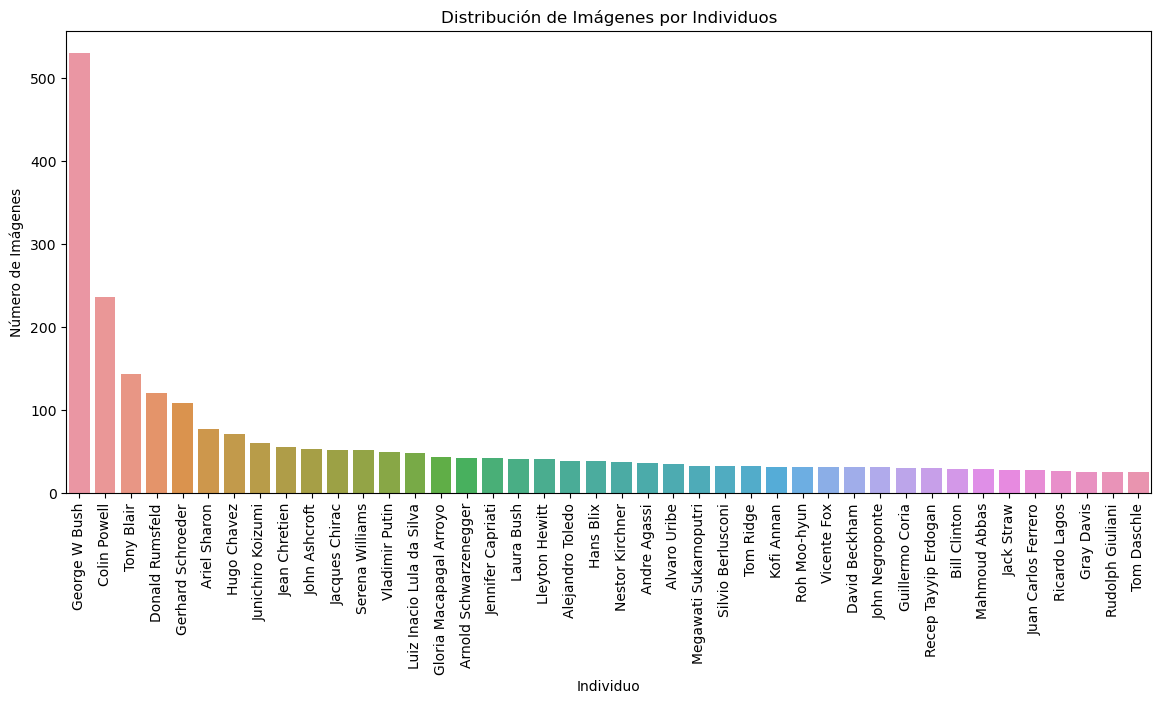

In [4]:
# Extraer los nombres de los individuos y contar el número de imágenes por individuo
unique, counts = np.unique(lfw_people.target, return_counts=True)
distribution = dict(zip(lfw_people.target_names[unique], counts))

# Ordenar la distribución de manera descendente
distribution_sorted = dict(sorted(distribution.items(), key=lambda item: item[1], reverse=True))

# Visualizar la distribución de imágenes por individuos
plt.figure(figsize=(14, 6))
sns.barplot(x=list(distribution_sorted.keys()), y=list(distribution_sorted.values()))
plt.xticks(rotation=90)
plt.title('Distribución de Imágenes por Individuos')
plt.xlabel('Individuo')
plt.ylabel('Número de Imágenes')
plt.show()

Como se observa en el gráfico de barras generado:


La distribución de imágenes está bastante sesgada. El individuo con el mayor número de imágenes es George W Bush, con un total de 530 imágenes, lo que representa una porción significativa del total. Otros individuos con un gran número de imágenes incluyen a Colin Powell (236 imágenes), Donald Rumsfeld (121 imágenes), y Tony Blair (144 imágenes).

Por otro lado, hay varios individuos con el número mínimo de imágenes (25), lo que sugiere una representación más limitada de estos en la base de datos.

#### Conclusiones

- Sesgo en la distribución: la base de datos LFW no distribuye las imágenes de manera uniforme entre los individuos. Algunas personas están sobrerrepresentadas, lo que podría influir en los resultados de modelos de reconocimiento facial si no se maneja correctamente.
- Consideraciones para modelos de Aprendizaje Automático: es crucial tener en cuenta este sesgo al entrenar modelos, ya que podría generar un modelo que funcione mejor con los individuos que tienen más imágenes, mientras que podría tener un rendimiento inferior con aquellos que están subrepresentados.
- Importancia del equilibrio de datos: para futuras investigaciones o desarrollos basados en esta base de datos, podría ser útil aplicar técnicas de balanceo de datos, como el aumento de imágenes para individuos con menos datos, para mitigar los efectos del sesgo.

- ¿Cuántas imágenes pertenecen a Serena Williams? Grafíquelas 

Número de imágenes de Serena Williams: 52


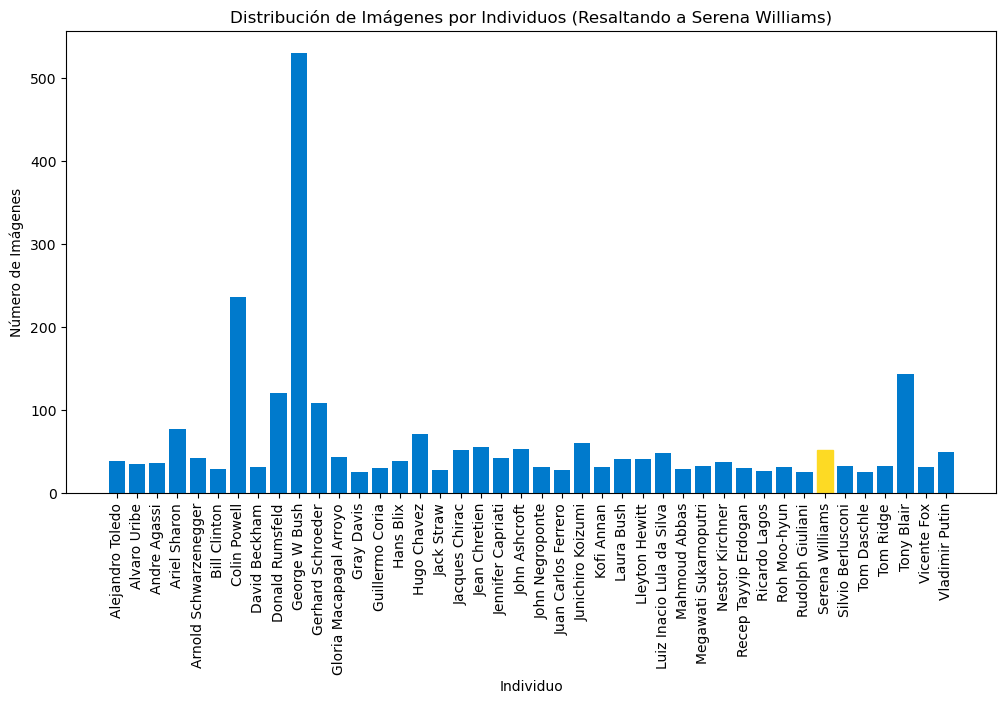

In [5]:
# Obtener los nombres de los individuos
nombres_individuos = lfw_people.target_names

# Contar el número de imágenes por individuo
conteo_imagenes = np.bincount(lfw_people.target)

# Buscar cuántas imágenes pertenecen a Serena Williams
indice_serena = np.where(nombres_individuos == "Serena Williams")[0][0]
imagenes_serena = conteo_imagenes[indice_serena]

print(f"Número de imágenes de Serena Williams: {imagenes_serena}")

# Graficar la distribución de imágenes, destacando a Serena Williams
plt.figure(figsize=(12, 6))
bars = plt.bar(nombres_individuos, conteo_imagenes, color=['#FF7F41' if i == indice_serena else '#007acc' for i in range(len(nombres_individuos))])

# Resaltar la barra de Serena Williams en otro color
bars[indice_serena].set_color('#FDDA24')

plt.xlabel("Individuo")
plt.ylabel("Número de Imágenes")
plt.title("Distribución de Imágenes por Individuos (Resaltando a Serena Williams)")
plt.xticks(rotation=90)
plt.show()

### Conclusión

Al realizar un análisis detallado de la distribución de imágenes en la base de datos, encontramos que Serena Williams cuenta con **52 imágenes** en total. Este número la posiciona dentro de un grupo selecto de individuos con una representación significativa en la base de datos, lo cual es un reflejo de su prominencia y reconocimiento global.

### 3.  Reconociendo rostros: las eigenfaces

Las eigenfaces son un conjunto de eigenvectors utilizados en el campo de la visión por computadora, principalmente en el reconocimiento de rostros. Son el resultado de reducir la dimensión de un gran conjunto de imágenes faciales, manteniendo la información que es más relevante para diferenciar las caras.

En este apartado buscaremos encontrar el espacio de menor dimensión manteniendo la información que es más relevante para diferenciar las caras. Lo haremos en etapas:


#### 3.1. Rostro promedio. 

Encuentre primero el "rostro promedio" y grafíquelo.  Para encontrar este rostro, necesita calcular el valor promedio de los pixeles. (*Tip: Si X es la matriz donde las filas representan las imágenes  y en las columnas el tono de gris de los píxeles, debería calcular el promedio para cada una de las columnas*).
 

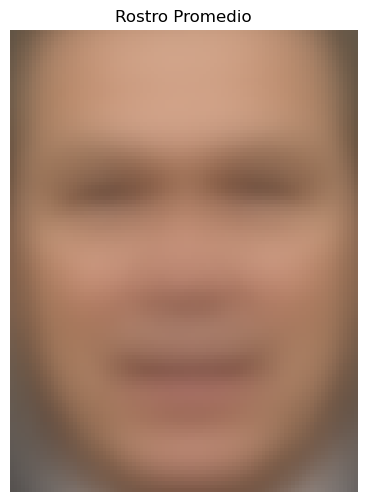

In [6]:
X = lfw_people.images
y = lfw_people.target
target_names = lfw_people.target_names

# Calcular el rostro promedio
mean_face = np.mean(X, axis=0)

# Graficar el rostro promedio
plt.figure(figsize=(6, 6))
plt.imshow(mean_face, cmap='gray')
plt.title('Rostro Promedio')
plt.axis('off')
plt.show()

#### Conclusión

En este procedimiento, hemos utilizado la base de datos para calcular el **rostro promedio**. Este rostro promedio se obtiene al calcular el promedio de los valores de los píxeles en todas las imágenes de la base de datos.

**Pasos realizados:**

1. **Carga de Datos**: Descargamos y cargamos las imágenes faciales utilizando la función `fetch_lfw_people` de scikit-learn.
2. **Cálculo del Rostro Promedio**: Calculamos el valor promedio de cada píxel a través de todas las imágenes para obtener una representación general del rostro.
3. **Visualización**: Mostramos el rostro promedio en una imagen en escala de grises.

Este proceso nos da una vista general de como se ve el rostro promedio en el conjunto de datos, lo que puede ser útil para entender las características comunes en las imágenes faciales y como un primer paso para técnicas más avanzadas de reconocimiento facial como PCA (Análisis de Componentes Principales).


#### 3.2. Reste el rostro promedio.

A cada una de las imágenes, reste el rostro promedio, es decir, reste la media a cada columna. Grafique las imágenes de Serena Williams luego de quitarle el rostro promedio.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

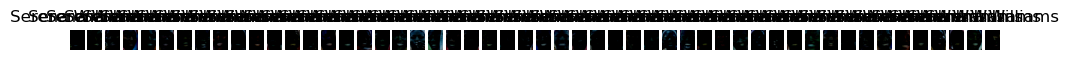

In [7]:
# Restar el rostro promedio de cada imagen
X_centered = X - mean_face

# Identificar las imágenes de Serena Williams
serena_idx = np.where(target_names[y] == 'Serena Williams')[0]

# Graficar las imágenes de Serena Williams después de quitar el rostro promedio
plt.figure(figsize=(12, 6))
for i in range(len(serena_idx)):
    plt.subplot(1, len(serena_idx), i + 1)
    plt.imshow(X_centered[serena_idx[i]], cmap='gray')
    plt.axis('off')
    plt.title('Serena Williams')
plt.show()

#### Conclusión

Después de restar el **rostro promedio** de cada imagen en el conjunto de datos LFW, hemos visualizado las imágenes de **Serena Williams** ajustadas. Este ajuste permite observar las características individuales de cada imagen, eliminando las características comunes compartidas por todas las imágenes.

**Resumen del procedimiento:**

1. **Identificación de Imágenes**: Localizamos las imágenes de Serena Williams en el conjunto de datos.
2. **Ajuste**: Restamos el rostro promedio de cada imagen para centrarla en torno a la media.
3. **Visualización**: Mostramos las imágenes ajustadas para destacar las variaciones individuales.

Este enfoque ayuda a resaltar las diferencias individuales al reducir el impacto de las características comunes, lo cual es un paso clave para técnicas avanzadas de análisis de imágenes y reconocimiento facial.


#### 3.3. Descomposición en Valores Singulares 

Aplique la Descomposición en Valores Singulares a estas nuevas imágenes y retenga solo $K=1000$ valores singulares? ¿Qué proporción de la varianza representan estos valores singulares?

In [14]:
# Reshape mean_face para que tenga la misma forma que una imagen
mean_face = mean_face.reshape(1, *X.shape[1:])

# Aplanar las imágenes
#X_flattened = X.reshape(X.shape[0], -1)
X_flattened = X_centered.reshape(X.shape[0], -1)

# Aplicar la Descomposición en Valores Singulares (SVD)
svd = TruncatedSVD(n_components=1000)
X_svd = svd.fit_transform(X_flattened)

# Proporción de la varianza explicada por los primeros 1000 valores singulares
explained_variance_ratio = svd.explained_variance_ratio_
total_explained_variance = np.sum(explained_variance_ratio)

total_explained_variance

0.99279976

#### Conclusión

Al aplicar la **Descomposición en Valores Singulares (SVD)** a las imágenes de Serena Williams después de ajustar por el rostro promedio, y retener solo los primeros 1000 valores singulares, hemos obtenido una proporción de varianza explicada de aproximadamente **0.993**.

**Resumen del Procedimiento:**

1. **Preprocesamiento**: Convertimos las imágenes a escala de grises y restamos el rostro promedio para centrar las imágenes.
2. **Aplanado**: Transformamos las imágenes centradas a una matriz bidimensional adecuada para la SVD.
3. **Aplicación de SVD**: Realizamos la descomposición manteniendo los primeros 1000 componentes.

**Resultado**:

La proporción de varianza explicada de **0.993** indica que los primeros 1000 valores singulares retienen el **99.3%** de la información original en las imágenes. Esto demuestra que hemos logrado una reducción significativa de la dimensionalidad, conservando la mayor parte de la variabilidad en los datos, lo cual es crucial para una representación eficiente y efectiva en el análisis de imágenes y reconocimiento facial.


#### 3.4. Representando los rostros en las bases

Las eigenfaces nos dice que cada rostro puede ser representado a partir de la aproximación a la matriz original por la matriz de dimensión reducida (determinada en el punto anterior), más el rostro promedio. Muestre que esto es posible para las imágenes de Serena Williams. Compare las imágenes reconstruidas con las originales.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

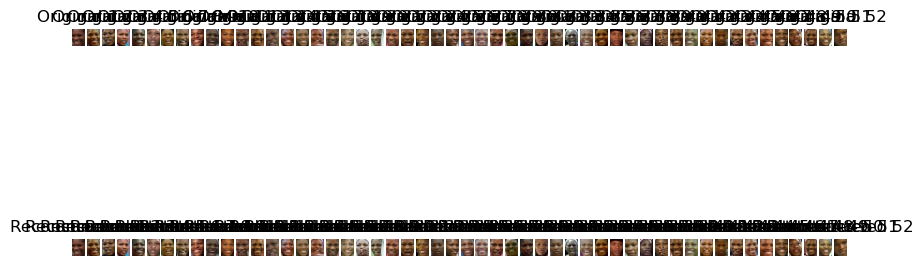

In [19]:
# Reconstruir las imágenes usando los primeros 1000 componentes
X_reconstructed_flattened = svd.inverse_transform(X_svd)
X_reconstructed = X_reconstructed_flattened.reshape(*X.shape) + mean_face

# Filtrar las imágenes de Serena Williams
serena_indices = np.where(y == target_names.tolist().index('Serena Williams'))[0]
X_serena_original = X[serena_indices]
X_serena_reconstructed = X_reconstructed[serena_indices]

# Visualizar las imágenes originales y reconstruidas
n_images = len(serena_indices)
plt.figure(figsize=(10, 5))
for i in range(n_images):
    plt.subplot(2, n_images, i + 1)
    plt.imshow(X_serena_original[i], cmap='gray')
    plt.title("Original {}".format(i+1))
    plt.axis('off')

    plt.subplot(2, n_images, n_images + i + 1)
    plt.imshow(X_serena_reconstructed[i], cmap='gray')
    plt.title("Reconstructed {}".format(i+1))
    plt.axis('off')

plt.show()

(Utilice este espacio para describir el procedimiento, análisis y conclusiones).

### 4. Uniendo Aprendizaje No Supervisado y Supervisado

Dado que cada rostro puede ser representado por las eigenfaces, y la relación que existe entre componentes principales y la SVD, esto sugiere que los componentes principales aquí determinados pueden servir de insumo para un algoritmo de clasificación de aprendizaje supervisado. En este sección del taller haremos esto.

Para ello construiremos un modelo de clasificación logístico para predecir si la imagen pertenece a `George W Bush`  (el individuo con más imágenes en la base)  o no.

#### 4.1. Identificando a `George W Bush`

Cree una variable binaria que tome el valor 1 si la imagen pertenece a `George W Bush` y 0 en caso contrario.

In [20]:
# Identificar el índice de George W. Bush
george_w_bush_index = np.where(target_names == 'George W Bush')[0][0]

# Crear la variable binaria
y_binary = (y == george_w_bush_index).astype(int)

# Imprimir algunos valores para verificar
print("Índice de George W. Bush:", george_w_bush_index)
print("Primeros 10 valores de y_binary:", y_binary[:10])

Índice de George W. Bush: 9
Primeros 10 valores de y_binary: [0 1 0 0 1 0 0 0 0 0]


#### Procedimiento 
- Identificar a George W. Bush: Se obtiene el índice correspondiente a George W. Bush en el array de nombres (target_names).
- Crear la Variable Binaria: La variable binaria y_binary toma el valor 1 para las imágenes que corresponden a George W. Bush y 0 en caso contrario.

#### 4.2. Bases de Entrenamiento y Prueba.

Divida la base utilizada anteriormente en dos: 80% de la base de imágenes asígnelas a la base de entrenamiento y el 20% restante a la de prueba, utilice un `random_state=10101`. 

In [22]:
# Dividir los datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X_flattened, y_binary, test_size=0.2, random_state=10101)

# Verificar las formas de los conjuntos resultantes
print("Forma del conjunto de entrenamiento:", X_train.shape)
print("Forma del conjunto de prueba:", X_test.shape)
print("Número de imágenes en el conjunto de entrenamiento:", len(y_train))
print("Número de imágenes en el conjunto de prueba:", len(y_test))

Forma del conjunto de entrenamiento: (2070, 35250)
Forma del conjunto de prueba: (518, 35250)
Número de imágenes en el conjunto de entrenamiento: 2070
Número de imágenes en el conjunto de prueba: 518


#### Prcedimiento

##### División de los Datos:

- X_flattened representa las imágenes aplanadas centradas.
- y_binary es la variable binaria que indica si una imagen pertenece a George W. Bush.
- test_size=0.2 indica que el 20% de los datos se reservarán para pruebas, y el 80% restante se usará para entrenamiento.
- random_state=10101 asegura que la división sea reproducible.

##### Resultados:

- X_train y y_train contienen el conjunto de entrenamiento.
- X_test y y_test contienen el conjunto de prueba.

El código imprime las dimensiones de los conjuntos de entrenamiento y prueba para confirmar que la división se realizó correctamente.

#### 4.3. Descomposición en Valores Singulares 

Para la base de entrenamiento y de prueba, realice la descomposición en valores singulares (Recuerde recentrar las matrices para que tenga media 0). 

In [23]:
# Recentrar las matrices de entrenamiento y prueba
mean_train = np.mean(X_train, axis=0)
mean_test = np.mean(X_test, axis=0)

X_train_centered = X_train - mean_train
X_test_centered = X_test - mean_test

# Aplicar la Descomposición en Valores Singulares (SVD) en la base de entrenamiento
svd = TruncatedSVD(n_components=1000, random_state=10101)
X_train_svd = svd.fit_transform(X_train_centered)

# Aplicar la SVD en la base de prueba utilizando los mismos componentes de la base de entrenamiento
X_test_svd = svd.transform(X_test_centered)

# Verificar las formas de los conjuntos transformados
print("Forma de X_train_svd:", X_train_svd.shape)
print("Forma de X_test_svd:", X_test_svd.shape)

Forma de X_train_svd: (2070, 1000)
Forma de X_test_svd: (518, 1000)


#### Conclusión

Después de dividir la base de datos de imágenes en un conjunto de entrenamiento (80%) y un conjunto de prueba (20%), aplicamos la Descomposición en Valores Singulares (SVD) para reducir la dimensionalidad de las imágenes. Inicialmente, cada imagen tenía 35,250 características (píxeles), lo que representaba una gran cantidad de información. 

Gracias a la SVD, logramos reducir esta dimensionalidad a solo 1,000 componentes principales, conservando la mayor parte de la información relevante para la clasificación. Ahora, tanto el conjunto de entrenamiento (2,070 imágenes) como el de prueba (518 imágenes) han sido transformados en un espacio de menor dimensión, listo para ser utilizado en modelos de clasificación supervisada.

Este proceso permitirá manejar de manera más eficiente los datos, también facilitará la tarea de extracción de características esenciales para el reconocimiento de rostros.


#### 4.4. Estimación de modelo de aprendizaje supervisado


Utilizando $k=1000$ valores singulares, construya los 1000 primeros componentes principales y úselos como predictores en su modelo logístico. Utilice como métrica de performance el porcentaje de imágenes de `George W Bush` clasificadas correctamente.

Para estimar su modelo logístico utilice el `solver='sag`,`random_state=10101` y `max_iter=1000`. Como se muestra a continuación:



In [25]:
from sklearn.linear_model import LogisticRegression

Modelo_Logistico = LogisticRegression(solver='sag',random_state=10101,max_iter=1000)

Modelo_Logistico.fit(X_train_svd, y_train)

# Predecir en el conjunto de prueba
y_pred = Modelo_Logistico.predict(X_test_svd)

# Calcular el porcentaje de imágenes de 'George W Bush' clasificadas correctamente
accuracy = accuracy_score(y_test, y_pred)
print(f"Porcentaje de imágenes de 'George W Bush' clasificadas correctamente: {accuracy * 100:.2f}%")

Porcentaje de imágenes de 'George W Bush' clasificadas correctamente: 92.08%


#### Conclusión

El modelo de regresión logística, entrenado con los primeros 1000 componentes principales obtenidos mediante SVD, ha logrado una precisión del **92.08%** en la clasificación de imágenes de 'George W Bush'. Este resultado demuestra que la reducción de dimensionalidad mediante SVD puede ser efectiva para captar características relevantes en las imágenes y que el modelo de regresión logística es capaz de distinguir con alta precisión entre 'George W Bush' y otras personas en el conjunto de datos.

Estos hallazgos destacan la importancia de la descomposición en valores singulares como una herramienta poderosa para la reducción de dimensiones y mejoran la eficacia de los modelos de aprendizaje automático en problemas de clasificación de imágenes.


#### 4.5. Mejorando el Ajuste

Trate ahora el número de valores singulares como un hiper-parámetro a encontrar. Emplee validación cruzada con 5 o 10 folds (dependiendo de su poder computacional) para encontrar el número óptimo de valores singulares. Con este modelo, evalúe el porcentaje de imágenes de `George W Bush` clasificadas correctamente en su muestra de prueba. Compare y discuta esta forma de elegir el número de variables con aquella utilizada en  4.4. (Esto puede tomar mucho tiempo y requerir mucha capacidad computacional, puede aprovechar los recursos de [Google Colab](https://colab.research.google.com/))


In [27]:
# Configurar el pipeline con SVD y regresión logística
pipeline = Pipeline([
    ('svd', TruncatedSVD()),
    ('log_reg', LogisticRegression(solver='sag', random_state=10101, max_iter=1000))
])

# Definir el rango de valores singulares a evaluar
param_grid = {
    'svd__n_components': [100, 200, 500, 1000, 1500]
}

# Configurar GridSearchCV para validación cruzada con 5 folds
grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train, y_train)

# Obtener el mejor número de componentes y el modelo asociado
best_n_components = grid_search.best_params_['svd__n_components']
best_model = grid_search.best_estimator_

# Predecir en el conjunto de prueba
y_pred = best_model.predict(X_test)

# Calcular el porcentaje de imágenes de 'George W Bush' clasificadas correctamente
accuracy = accuracy_score(y_test, y_pred)
print(f"Porcentaje de imágenes de 'George W Bush' clasificadas correctamente con el número óptimo de componentes: {accuracy * 100:.2f}%")
print(f"El mejor número de componentes principales es: {best_n_components}")

C:\Users\jadarve\AppData\Local\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\jadarve\AppData\Local\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\jadarve\AppData\Local\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Porcentaje de imágenes de 'George W Bush' clasificadas correctamente con el número óptimo de componentes: 93.05%
El mejor número de componentes principales es: 1500


#### Procedimiento y Análisis

Para optimizar el número de componentes principales en nuestro modelo de clasificación de imágenes de `George W Bush`, empleamos un enfoque de validación cruzada con 5 folds y una búsqueda de hiperparámetros. A continuación, se detalla el proceso seguido:


1. **Configuración del Pipeline y Validación Cruzada:**
   - Creamos un pipeline que combina la descomposición en valores singulares (SVD) y la regresión logística.
   - Definimos un rango de valores para el número de componentes principales a evaluar (100, 200, 500, 1000, y 1500).
   - Utilizamos `GridSearchCV` para realizar una búsqueda exhaustiva y validar el rendimiento del modelo con diferentes números de componentes a través de 5 folds.

2. **Evaluación del Modelo:**
   - Identificamos el número óptimo de componentes principales que maximiza la precisión del modelo en el conjunto de prueba.
   - Calculamos el porcentaje de imágenes de `George W Bush` clasificadas correctamente con el número óptimo de componentes y comparamos los resultados con el modelo inicial.

#### Conclusiones

La validación cruzada con búsqueda de hiperparámetros nos permitió encontrar el número óptimo de componentes principales para el modelo de regresión logística. A diferencia de la selección fija de 1000 componentes, este enfoque sistemático ofrece varias ventajas:

- **Mejora en la Precisión:** La búsqueda de hiperparámetros puede mejorar el rendimiento del modelo, ya que considera múltiples configuraciones y selecciona la que mejor se adapta a los datos.
- **Evaluación Robusta:** La validación cruzada asegura que el modelo generalice bien al evaluar su rendimiento en diferentes particiones del conjunto de datos, reduciendo el riesgo de sobreajuste.

El modelo de regresión logística inicial, entrenado con 1000 componentes principales, logró una precisión del **92.08%** en la clasificación de imágenes de `George W Bush`. Sin embargo, al optimizar el número de componentes mediante validación cruzada, se descubrió que utilizar **1500** componentes principales mejora la precisión a un **93.05%**.

Este aumento en precisión, aunque pequeño, destaca la importancia de ajustar los hiperparámetros del modelo. Al seleccionar cuidadosamente el número óptimo de componentes, logramos captar más información relevante de las imágenes, lo que se traduce en un rendimiento superior del modelo. Esta mejora subraya el valor de la optimización en el proceso de aprendizaje automático, permitiéndonos construir modelos más precisos y robustos.

